In [2]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.pipeline import make_pipeline

In [3]:
# get working directory and set up path for files
working_dir = os.getcwd()
file = os.path.join(working_dir,'Beauty_5.json')
metadata = os.path.join(working_dir,'meta_Beauty.json')

In [4]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)


def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [5]:
# import metadata
df = getDF('meta_Beauty.json.gz')

In [6]:
# select only products in the Skin Care/Face categories
df['test']=df.categories.apply(lambda x: x[0])
df['test']= df.test.apply(lambda x: True if ('Face' in x) and ('Skin Care' in x) else False )
df_cat = df[df.test]

In [7]:
# import reviews
df_review = getDF('reviews_Beauty_5.json.gz')

In [9]:
# merge reviews and metadata
product_review = pd.merge(df_cat, df_review, on=['asin'], suffixes=['', '_review'], how='inner')
product_review.columns
product_review=product_review.drop(['categories', 'related', 'test', 'reviewerName', 'helpful', 'summary',
       'unixReviewTime', 'reviewTime'], axis=1)

In [11]:
print(len(product_review))
print(product_review.asin.nunique())
print(product_review.reviewerID.nunique())

36829
1979
13048


In [12]:
# number of reviews per products and other descriptive stats
product_review_group = product_review.pivot_table(index='asin', values='reviewerID', aggfunc=np.ma.count)
product_review_group.describe()
# min of 5 is correct because our base table is the table with min 5 review for each product

,reviewerID
count,1979.000000
mean,18.609904
std,26.876105
min,5.000000
25%,6.000000
50%,10.000000
75%,18.000000
max,403.000000


In [13]:
# number of reviews per reviewer and other descriptive stats
# product_reviewer_group_ = product_review.groupby(['reviewerID'])['asin'].count().reset_index()
product_reviewer_group = product_review.pivot_table(index='reviewerID', values='asin', aggfunc=np.ma.count)
product_reviewer_group.describe()
# min of 1 even though our base table is the table with min 5 review for each reviewer; this is because we match with
# the metadata table and limit to only skincare/face categories. Reviews in the other categories have been dropped.


,asin
count,13048.000000
mean,2.822578
std,2.877034
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,78.000000


In [14]:
print(len(product_reviewer_group[product_reviewer_group.asin>=5]))
# 1910, too low, so keep at least 2?
print(len(product_reviewer_group[product_reviewer_group.asin>=3]))
# 5168
# but then we have to watch the number of reviews as well

1910
5168


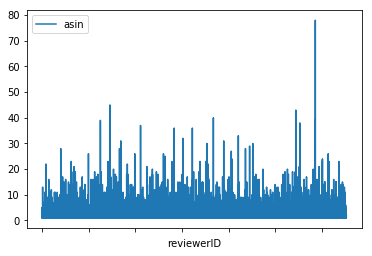

In [31]:
product_reviewer_group.plot()

(array([1.2582e+04, 3.7700e+02, 6.3000e+01, 1.4000e+01, 8.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 1. ,  8.7, 16.4, 24.1, 31.8, 39.5, 47.2, 54.9, 62.6, 70.3, 78. ]),
 <a list of 10 Patch objects>)

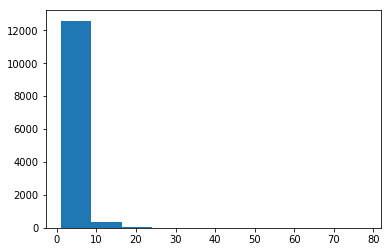

In [28]:
# bar chart to visualize distribution of reviews for each person
plt.hist(product_reviewer_group.asin)

(array([1.79e+03, 1.29e+02, 4.00e+01, 1.00e+01, 5.00e+00, 2.00e+00,
        1.00e+00, 0.00e+00, 0.00e+00, 2.00e+00]),
 array([  5. ,  44.8,  84.6, 124.4, 164.2, 204. , 243.8, 283.6, 323.4,
        363.2, 403. ]),
 <a list of 10 Patch objects>)

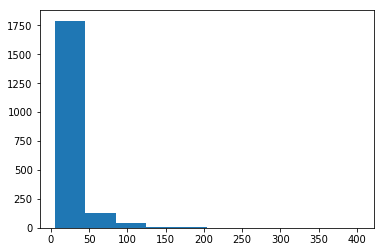

In [29]:
plt.hist(product_review_group.reviewerID)

In [19]:
# transform to pivot table and sparse matrix
# https://towardsdatascience.com/how-did-we-build-book-recommender-systems-in-an-hour-part-2-k-nearest-neighbors-and-matrix-c04b3c2ef55c
product_review_pivot = product_review.pivot_table(index='asin', columns='reviewerID', values='overall').fillna(0)
product_review_matrix = csr_matrix(product_review_pivot)
print(product_review_matrix.shape)

(1979, 13048)


In [20]:
# Create a MaxAbsScaler: scaler
scaler = MaxAbsScaler()
# MaxAbsScaler, transforms the data so that all users have the same influence on the model, regardless of how many products they used.


In [21]:
# Create an NMF model: nmf
nmf = NMF(n_components=20)


In [22]:
# Create a Normalizer: normalizer
normalizer = Normalizer()


In [23]:
# Create a pipeline: pipeline
pipeline = make_pipeline(scaler, nmf, normalizer)

# Apply fit_transform to artists: norm_features
norm_features = pipeline.fit_transform(product_review_matrix)

In [24]:
df_nmf = pd.DataFrame(norm_features, index=product_review_pivot.index)
df_nmf_t = pd.merge(df_nmf, df_cat, left_on=df_nmf.index, right_on='asin', how='left')
df_nmf_prod = pd.DataFrame(norm_features, index=df_nmf_t.title)


In [25]:
# example: find products similar to "Cetaphil Gentle Skin Cleanser"
product = df_nmf_prod.loc['Cetaphil Gentle Skin Cleanser - 16 fl oz']

In [26]:
# Compute cosine similarities: similarities
similarities = df_nmf_prod.dot(product)

# Display those with highest cosine similarity
print(similarities.nlargest())


title
Cetaphil Gentle Skin Cleanser - 16 fl oz                               1.000000
Neutrogena Ageless Restoratives Anti-Oxidant Booster Serum, 1 Ounce    0.972343
RoC Deep Wrinkle Serum, 1 Ounce                                        0.946497
RoC Deep Wrinkle Daily Moisturizer SPF30, 1 Ounce                      0.945755
RoC Daily Resurfacing Disks, 3 Inch, 28 Disks                          0.944919
dtype: float64
